# FYP-DL: SVM - Countering Imbalance via Class Weights

Training on 20% of the original training data because I want to get quick results. 

# Imports

In [1]:
# For loading data from Drive
from google.colab import drive, files

# Standard Imports
import pandas as  pd
import os 
import numpy as np

from matplotlib import pyplot as plt 
%matplotlib inline 
from matplotlib import style 
style.use('ggplot')

# Sklearn - Model Selection
from sklearn.model_selection import RandomizedSearchCV, train_test_split 

# Sklearn - Model Evaluation 
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, \
plot_confusion_matrix, plot_roc_curve

# Sklearn - SVC
from sklearn.svm import SVC

# Sklearn - Class Weights
from sklearn.utils.class_weight import compute_class_weight

# Random Number Seeding
np.random.seed(0)

In [2]:
def get_classification_result(estimator, X, y_true, classifier_name=None,
                              normalize_conf_mat='all'):
    """Custom function to display classification results"""
    # Predictions will be used several times
    y_pred = estimator.predict(X) 

    # Display the classification report 
    print("CLASSIFICATION REPORT")
    print(classification_report(y_true, y_pred, labels=[0, 1], 
                                target_names=['Regular Consumer', 'Thieves'],))
    
    # Display the confusion matrix
    print("CONFUSION MATRIX")
    if (normalize_conf_mat=='rows'):
      normalize='true'
    elif (normalize_conf_mat=='cols'):
        normalize='pred'
    else:
      normalize=normalize_conf_mat

    # Use built-in function to get confusion matrix for this estimator
    conf_mat_display = plot_confusion_matrix(estimator=estimator, 
                                             X=X, 
                                             y_true=y_true, 
                                             labels=[0, 1],
                                             normalize=normalize, 
                                             display_labels=['Regular Consumers', 'Thieves'], 
                                             cmap=plt.cm.Blues)
    
    # Add a title (with optional classifier name)
    conf_mat_display.ax_.set_title("Confusion Matrix - {}".format(
        classifier_name if classifier_name is not None 
        else 'Test Classifier' ))
    
    # This will render the confusion matrix as an image
    print(conf_mat_display.confusion_matrix);
    plt.grid(False)       # Remove extra lines from confusion matrix

    roc_curve_display = plot_roc_curve(estimator, X, y_true)
    roc_curve_display.ax_.set_title('ROC Curve' +
                                    ('' if classifier_name is None else ' - {}'.format(classifier_name)), 
                                    fontsize=18);

# Importing Modules

In [3]:
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/pipelines.py"
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/plot_utils.py"
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/wdnn_transformers.py"
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/build_WDNN.py"

# Loading Data

In [4]:
# Mount Google Drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
# Defining filepaths
ROOT_DIR = "/content/drive/My Drive"
FYP_DIR = "EE 16-17 FYP DL Energy Theft Detection"
DATA_DIR = "Data/full-processing-data"
FILE_NAME = "outliersRemoved.csv"

In [6]:
# Create filepath
FILE_PATH = os.path.join(ROOT_DIR, FYP_DIR, DATA_DIR, FILE_NAME)

In [7]:
# Print the filepath for checking
print(FILE_PATH)

/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/Data/full-processing-data/outliersRemoved.csv


In [8]:
df = pd.read_csv(FILE_PATH)
df.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,8.56,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.93,11.41,19.92,10.70,9.20,6.77,6.760000,6.150000,6.500000,8.080000,7.97,8.810000,7.370000,11.720000,11.020000,8.180000,7.330000,6.710000,8.520000,6.310000,7.18,8.070000,8.090000,9.530000,5.480000,8.750000,9.300000,7.540000,9.160000,6.740000
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.34,13.483126,13.483126,13.483126,13.483126,12.73,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,10.95,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,17.30,16.95,8.25,22.76,14.07,20.70,6.50,9.99,18.59,16.79,26.82,14.70,16.05,24.10,12.64,10.85,11.770000,13.030000,12.260000,15.660000,13.43,15.030000,14.610000,13.970000,15.070000,14.110000,14.770000,11.720000,11.730000,11.980000,12.81,15.120000,17.260000,14.910000,19.590000,20.790000,17.950000,19.260000,14.460000,11.720000
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,0.88,3.81,6.51,9.19,7.79,7.02,7.25,6.37,6.43,7.89,7.46,7.95,7.59,4.84,6.06,5.6,6.72,7.29,5.6,6.28,...,9.56,9.48,10.60,10.06,10.79,10.91,17.77,10.37,13.51,14.13,17.44,15.96,12.18,18.54,13.44,11.68,9.150000,9.160000,10.190000,10.310000,8.03,10.080000,10.340000,11.240000,15.140000,14.360000,12.390000,10.360000,9.290000,7.910000,14.21,10.220000,8.470000,6.110000,6.100000,6.730000,7.520000,10.890000,9.860000,8.720000


# Train-Test Split

In [9]:
features, labels = df.iloc[:, 2:], df.iloc[:, 1]

In [10]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features, labels, 
                                                    train_size=0.4, 
                                                    random_state=0, 
                                                    stratify=labels.values)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                  random_state=0, 
                                                  test_size=0.2, 
                                                  stratify=y_train_val.values)

# Feature Scaling - Standard

In [12]:
# Import the pipeline functions from the pipeline modules
from pipelines import get_pipeline_1D, get_pipeline_2D

# Creating pipeline objects
pipeline_1D_std = get_pipeline_1D(scaling_strategy='Standard')

# Fit and then transform the pipelines to the training data first 
X_train_val_1D_std = pipeline_1D_std.fit_transform(X_train_val)
X_train_1D_std = pipeline_1D_std.fit_transform(X_train)
X_val_1D_std = pipeline_1D_std.fit_transform(X_val)
X_test_1D_std = pipeline_1D_std.fit_transform(X_test)

# Feature Scaling - MinMax

In [13]:
# Creating pipeline objects
pipeline_1D_minmax = get_pipeline_1D(scaling_strategy='MinMax')

# Fit and then transform the pipelines to the training data first 
X_train_val_1D_minmax = pipeline_1D_minmax.fit_transform(X_train_val)
X_train_1D_minmax = pipeline_1D_minmax.fit_transform(X_train)
X_val_1D_minmax = pipeline_1D_minmax.fit_transform(X_val)
X_test_1D_minmax = pipeline_1D_minmax.fit_transform(X_test)

# 01 - Class Weights from `sklearn` API

In [14]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train_val
)

In [15]:
# Create a dictionary that can be passed to an `sklearn` estimator
cw_sklearn = dict(zip([0, 1], class_weights))

# Output this: does it make sense?
cw_sklearn

{0: 0.5466391433363437, 1: 5.860304287690179}

# SVC 01 - Standard, Unweighted Loss

In [22]:
print("Training Set Size: ", X_train_1D_std.shape[0])
print("Validation Set Size: ", X_val_1D_std.shape[0])

Training Set Size:  13558
Validation Set Size:  3390


In [24]:
svc_std = SVC(C = 1.0, kernel='rbf', random_state=0, verbose=True)
svc_std.fit(X_train_1D_std, y_train)

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=True)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.91      1.00      0.96      3101
         Thieves       0.00      0.00      0.00       289

        accuracy                           0.91      3390
       macro avg       0.46      0.50      0.48      3390
    weighted avg       0.84      0.91      0.87      3390

CONFUSION MATRIX


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[1. 0.]
 [1. 0.]]


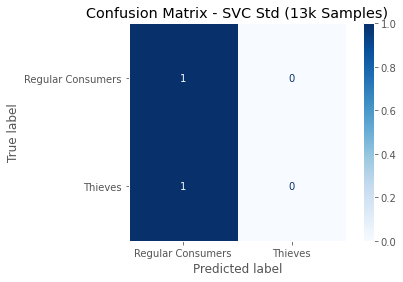

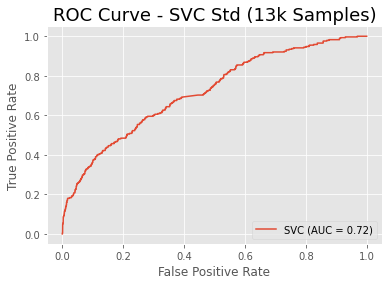

In [25]:
get_classification_result(svc_std, X_val_1D_std, y_val, 
                          "SVC Std (13k Samples)", normalize_conf_mat="rows")

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.91      1.00      0.96      3101
         Thieves       0.00      0.00      0.00       289

        accuracy                           0.91      3390
       macro avg       0.46      0.50      0.48      3390
    weighted avg       0.84      0.91      0.87      3390

CONFUSION MATRIX


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[0.91474926 0.        ]
 [0.08525074 0.        ]]


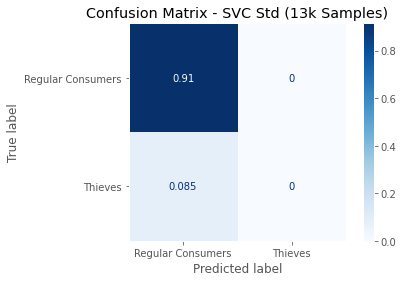

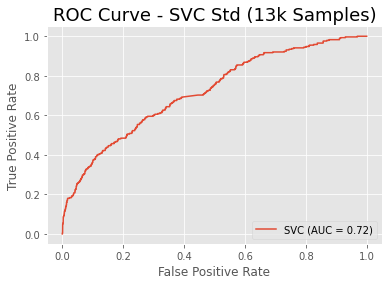

In [26]:
get_classification_result(svc_std, X_val_1D_std, y_val, 
                          "SVC Std (13k Samples)", normalize_conf_mat="cols")

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.91      1.00      0.96      3101
         Thieves       0.00      0.00      0.00       289

        accuracy                           0.91      3390
       macro avg       0.46      0.50      0.48      3390
    weighted avg       0.84      0.91      0.87      3390

CONFUSION MATRIX


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[0.91474926 0.        ]
 [0.08525074 0.        ]]


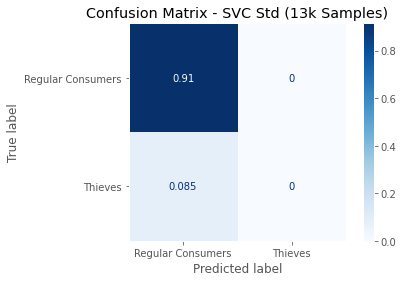

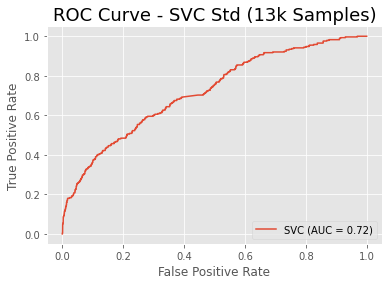

In [27]:
get_classification_result(svc_std, X_val_1D_std, y_val, 
                          "SVC Std (13k Samples)", normalize_conf_mat="all")

# SVC 02 - Standard, Weighted Loss

In [28]:
svc_std_weighted = SVC(C = 1.0, kernel='rbf', random_state=0, verbose=0, 
                       class_weight=cw_sklearn, verbose=1)

In [29]:
svc_std_weighted.fit(X_train_1D_std, y_train)

SVC(C=1.0, break_ties=False, cache_size=200,
    class_weight={0: 0.5466391433363437, 1: 5.860304287690179}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=0)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.95      0.82      0.88      3101
         Thieves       0.21      0.51      0.30       289

        accuracy                           0.79      3390
       macro avg       0.58      0.67      0.59      3390
    weighted avg       0.88      0.79      0.83      3390

CONFUSION MATRIX
[[0.75132743 0.16342183]
 [0.04159292 0.04365782]]


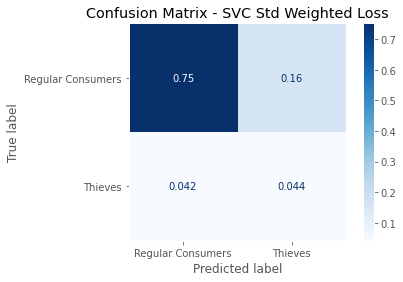

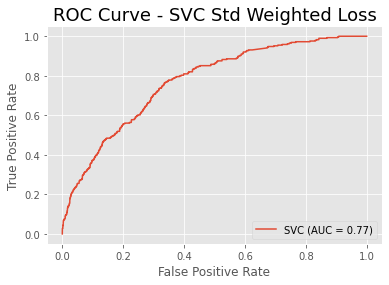

In [30]:
get_classification_result(svc_std_weighted, X_val_1D_std, y_val, 
                          "SVC Std Weighted Loss")

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.95      0.82      0.88      3101
         Thieves       0.21      0.51      0.30       289

        accuracy                           0.79      3390
       macro avg       0.58      0.67      0.59      3390
    weighted avg       0.88      0.79      0.83      3390

CONFUSION MATRIX
[[0.82134795 0.17865205]
 [0.48788927 0.51211073]]


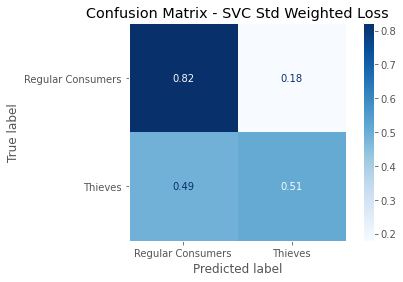

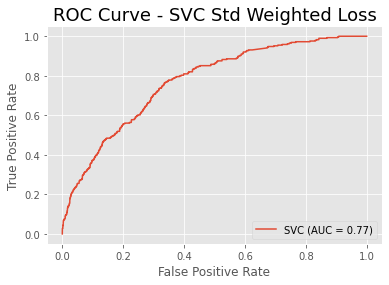

In [31]:
get_classification_result(svc_std_weighted, X_val_1D_std, y_val, 
                          "SVC Std Weighted Loss", "rows")

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.95      0.82      0.88      3101
         Thieves       0.21      0.51      0.30       289

        accuracy                           0.79      3390
       macro avg       0.58      0.67      0.59      3390
    weighted avg       0.88      0.79      0.83      3390

CONFUSION MATRIX
[[0.94754464 0.78917379]
 [0.05245536 0.21082621]]


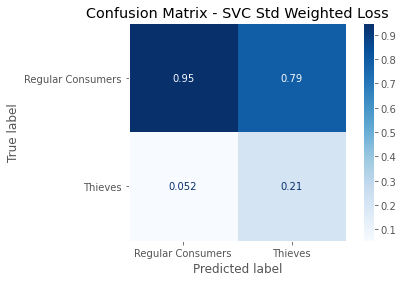

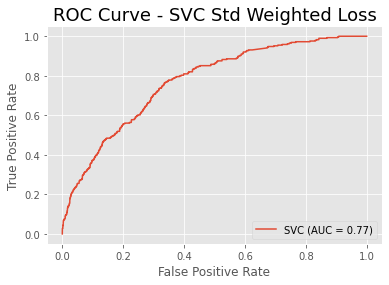

In [32]:
get_classification_result(svc_std_weighted, X_val_1D_std, y_val, 
                          "SVC Std Weighted Loss", "cols")

# SVC 03 - MinMax

In [16]:
svc_minmax = SVC(C = 1.0, kernel='rbf', random_state=0, verbose=True)
svc_minmax.fit(X_train_1D_minmax, y_train)

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=True)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.91      1.00      0.96      3101
         Thieves       0.00      0.00      0.00       289

        accuracy                           0.91      3390
       macro avg       0.46      0.50      0.48      3390
    weighted avg       0.84      0.91      0.87      3390

CONFUSION MATRIX


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[0.91474926 0.        ]
 [0.08525074 0.        ]]


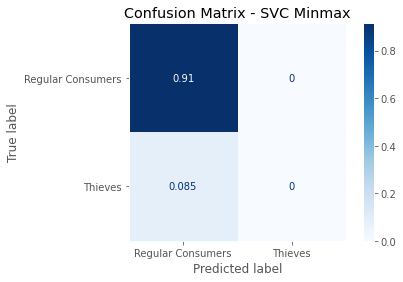

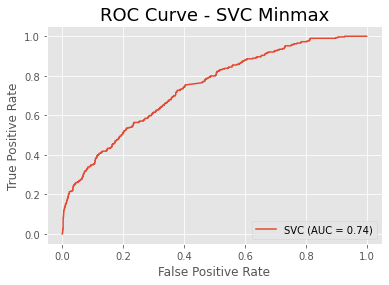

In [17]:
get_classification_result(svc_minmax, X_val_1D_minmax, y_val, 
                          "SVC Minmax")

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.91      1.00      0.96      3101
         Thieves       0.00      0.00      0.00       289

        accuracy                           0.91      3390
       macro avg       0.46      0.50      0.48      3390
    weighted avg       0.84      0.91      0.87      3390

CONFUSION MATRIX


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[1. 0.]
 [1. 0.]]


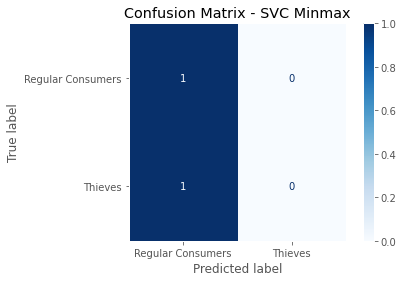

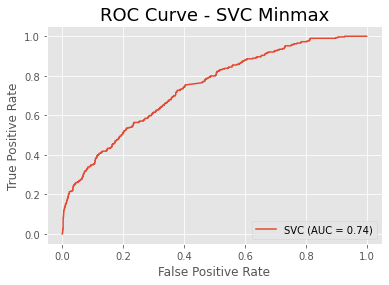

In [18]:
get_classification_result(svc_minmax, X_val_1D_minmax, y_val, 
                          "SVC Minmax", "rows")

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.91      1.00      0.96      3101
         Thieves       0.00      0.00      0.00       289

        accuracy                           0.91      3390
       macro avg       0.46      0.50      0.48      3390
    weighted avg       0.84      0.91      0.87      3390

CONFUSION MATRIX


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[0.91474926 0.        ]
 [0.08525074 0.        ]]


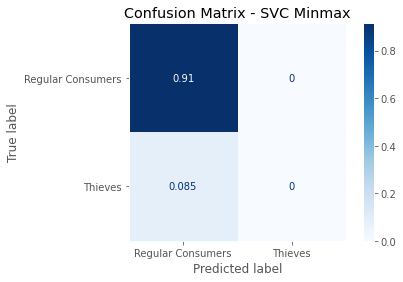

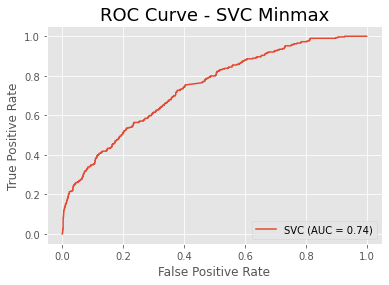

In [19]:
get_classification_result(svc_minmax, X_val_1D_minmax, y_val, 
                          "SVC Minmax", "cols")

# SVC 04 - Weighted MinMax

In [20]:
svc_minmax_weighted = SVC(C = 1.0, kernel='rbf', random_state=0, verbose=True,
                          class_weight=cw_sklearn)
svc_minmax_weighted.fit(X_train_1D_minmax, y_train)

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200,
    class_weight={0: 0.5466391433363437, 1: 5.860304287690179}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=True)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.95      0.85      0.90      3101
         Thieves       0.25      0.55      0.35       289

        accuracy                           0.82      3390
       macro avg       0.60      0.70      0.62      3390
    weighted avg       0.89      0.82      0.85      3390

CONFUSION MATRIX
[[0.77787611 0.13687316]
 [0.03864307 0.04660767]]


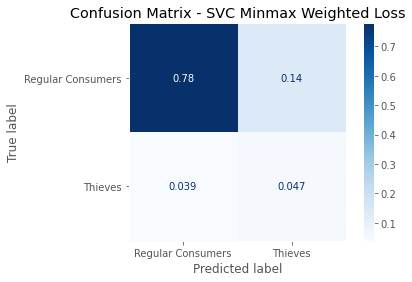

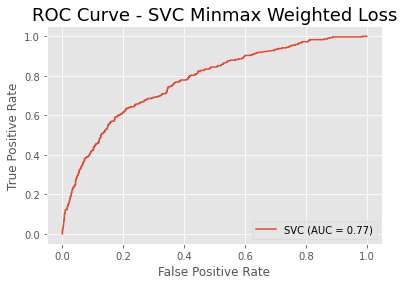

In [21]:
get_classification_result(svc_minmax_weighted, X_val_1D_minmax, y_val, 
                          "SVC Minmax Weighted Loss")

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.95      0.85      0.90      3101
         Thieves       0.25      0.55      0.35       289

        accuracy                           0.82      3390
       macro avg       0.60      0.70      0.62      3390
    weighted avg       0.89      0.82      0.85      3390

CONFUSION MATRIX
[[0.85037085 0.14962915]
 [0.4532872  0.5467128 ]]


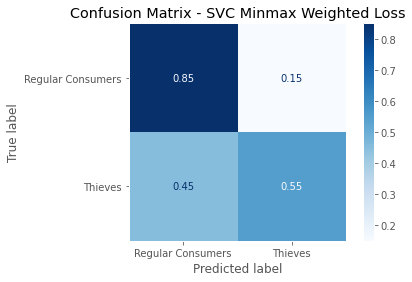

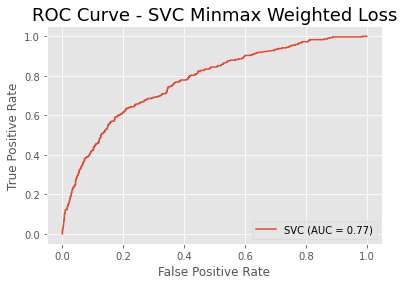

In [22]:
get_classification_result(svc_minmax_weighted, X_val_1D_minmax, y_val, 
                          "SVC Minmax Weighted Loss", "rows")

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.95      0.85      0.90      3101
         Thieves       0.25      0.55      0.35       289

        accuracy                           0.82      3390
       macro avg       0.60      0.70      0.62      3390
    weighted avg       0.89      0.82      0.85      3390

CONFUSION MATRIX
[[0.95267341 0.74598071]
 [0.04732659 0.25401929]]


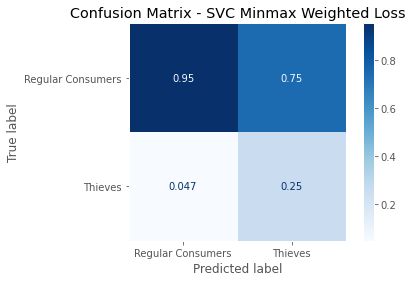

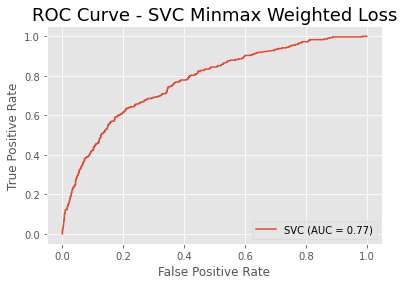

In [23]:
get_classification_result(svc_minmax_weighted, X_val_1D_minmax, y_val, 
                          "SVC Minmax Weighted Loss", "cols")